✅ تبدیل موفقیت آمیز بود.
فایل خروجی در این مسیر ذخیره شد: E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2020\prediction2020_converted.tif


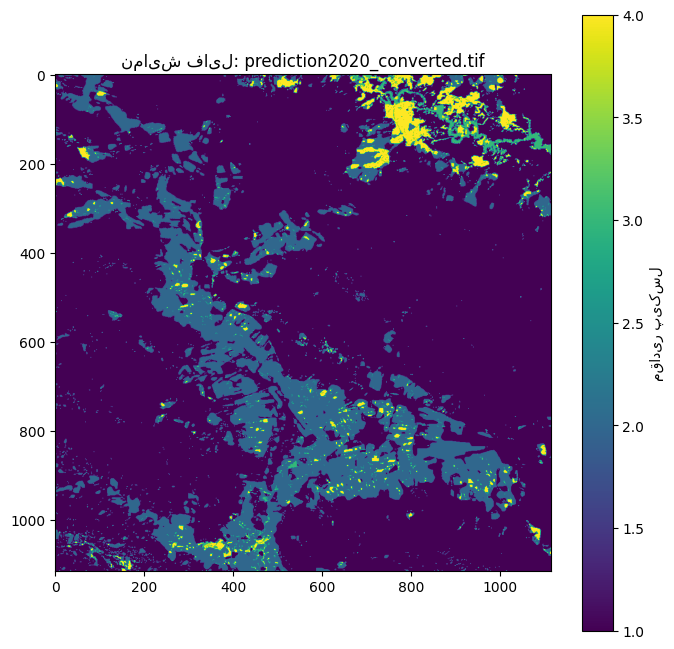

In [10]:
import rasterio
import matplotlib.pyplot as plt
import os

def convert_rst_to_tiff(rst_path, tiff_path):
    """
    یک فایل .rst را به فایل GeoTIFF .tif تبدیل می‌کند.
    """
    try:
        with rasterio.open(rst_path) as src:
            data = src.read(1)
            meta = src.meta.copy()
            meta.update(driver='GTiff')
            with rasterio.open(tiff_path, 'w', **meta) as dst:
                dst.write(data, 1)
        print(f"✅ تبدیل موفقیت آمیز بود.")
        print(f"فایل خروجی در این مسیر ذخیره شد: {tiff_path}")
        return True # در صورت موفقیت True را برمی‌گرداند
    except Exception as e:
        print(f"❌ خطا در تبدیل فایل: {e}")
        return False # در صورت شکست False را برمی‌گرداند

def display_tiff(tiff_path):
    """
    یک فایل GeoTIFF را باز کرده و نمایش می‌دهد.
    """
    try:
        with rasterio.open(tiff_path) as src:
            data = src.read(1)
            plt.figure(figsize=(8, 8))
            plt.imshow(data, cmap='viridis')
            plt.colorbar(label='مقادیر پیکسل')
            plt.title(f'نمایش فایل: {os.path.basename(tiff_path)}')
            plt.show()
    except Exception as e:
        print(f"❌ خطا در نمایش فایل: {e}")

# --- تعریف مسیرها ---

# مسیری که شما ارائه دادید
directory_path = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2020'

# !!! توجه: اگر نام فایل شما متفاوت است، آن را در اینجا تغییر دهید
rst_filename = 'prediction2020.rst'
tiff_filename = 'prediction2020_converted.tif'

# ایجاد مسیر کامل برای فایل ورودی و خروجی
input_rst = os.path.join(directory_path, rst_filename)
output_tiff = os.path.join(directory_path, tiff_filename)


# --- اجرای اصلی: تبدیل و سپس نمایش ---
if os.path.exists(input_rst):
    # ابتدا تبدیل را انجام می‌دهیم
    success = convert_rst_to_tiff(input_rst, output_tiff)
    
    # اگر تبدیل موفق بود، فایل را نمایش می‌دهیم
    if success:
        display_tiff(output_tiff)
else:
    print(f"❌ خطا: فایل در مسیر زیر یافت نشد:")
    print(input_rst)
    print("لطفاً از صحت نام فایل و مسیر پوشه اطمینان حاصل کنید.")

In [19]:
import rasterio
import numpy as np
import os

def analyze_land_cover_change(predicted_tiff, actual_tiff):
    """
    Analyzes and reports the area and percentage of land cover change
    between a predicted and an actual GeoTIFF file.
    The output is in English and formatted for clarity.
    """
    print(f"Comparing '{os.path.basename(predicted_tiff)}' against '{os.path.basename(actual_tiff)}'...")
    try:
        with rasterio.open(predicted_tiff) as pred_src, rasterio.open(actual_tiff) as actual_src:
            # --- 1. Data and Metadata Reading ---
            pred_data = pred_src.read(1)
            actual_data = actual_src.read(1)
            transform = actual_src.transform
            crs = actual_src.crs

            if pred_data.shape != actual_data.shape:
                print("❌ ERROR: Raster shapes do not match. Please ensure both rasters have the same dimensions.")
                return

            
            pixel_area_sq_meters = 0
            

            # --- 3. Change Calculation ---
            changed_pixels_matrix = np.where(pred_data != actual_data, 1, 0)
            num_changed_pixels = np.sum(changed_pixels_matrix)
            total_pixels = pred_data.size

            print("\n" + "="*25 + " ANALYSIS SUMMARY " + "="*25)
            print(f"Total Changed Pixels: {num_changed_pixels:,}")

            if pixel_area_sq_meters > 0:
                total_change_area_sq_km = (num_changed_pixels * pixel_area_sq_meters) / 1_000_000
                print(f"Total Area of Change: {total_change_area_sq_km:,.2f} sq. km")
            print("="*70)

            # --- 4. Detailed Confusion Matrix ---
            classes = sorted(np.unique(np.concatenate((pred_data, actual_data))))
            num_classes = len(classes)
            class_mapping = {val: i for i, val in enumerate(classes)}

            change_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
            for r in range(pred_data.shape[0]):
                for c in range(pred_data.shape[1]):
                    actual_val = actual_data[r, c]
                    pred_val = pred_data[r, c]
                    if actual_val in class_mapping and pred_val in class_mapping:
                        change_matrix[class_mapping[actual_val], class_mapping[pred_val]] += 1
            
            # --- 5. Formatted Output Table ---
            print("\nChange Matrix (% of Total Landscape)")
            
            # Header
            header = f"{'ACTUAL':<10}" + "".join([f"{'PRED_' + str(c):^12}" for c in classes])
            print(header)
            print("-" * len(header))

            # Rows
            for i, actual_class in enumerate(classes):
                row_str = f"{'CLASS_' + str(actual_class):<10}"
                for j, _ in enumerate(classes):
                    percentage = (change_matrix[i, j] / total_pixels) * 100
                    row_str += f"{percentage:^12.2f}"
                print(row_str)
            print("-" * len(header))
            
            # --- 6. Overall Accuracy ---
            correct_pixels = np.trace(change_matrix)
            accuracy = (correct_pixels / total_pixels) * 100
            print(f"\nOverall Accuracy: {accuracy:.2f}%\n")


    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# --- File Path Definitions ---

# Path to the predicted TIF file (output of the previous script)
predicted_dir = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2020'
predicted_filename = 'prediction2020_converted.tif'
predicted_tiff_path = os.path.join(predicted_dir, predicted_filename)

# Path to your actual TIF file
actual_dir = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\new_classified'
# !!! NOTE: Assumed the actual filename is 'reclassify2020.tif'. Change if necessary.
actual_filename = 'reclassify2020.tif'
actual_tiff_path = os.path.join(actual_dir, actual_filename)

# --- Main Execution Block ---
if not os.path.exists(predicted_tiff_path):
    print(f"❌ ERROR: Predicted file not found at: {predicted_tiff_path}")
elif not os.path.exists(actual_tiff_path):
    print(f"❌ ERROR: Actual file not found at: {actual_tiff_path}")
else:
    analyze_land_cover_change(predicted_tiff_path, actual_tiff_path)

Comparing 'prediction2020_converted.tif' against 'reclassify2020.tif'...

========================= ANALYSIS SUMMARY =========================
Total Changed Pixels: 239,591

Change Matrix (% of Total Landscape)
ACTUAL       PRED_1      PRED_2      PRED_3      PRED_4   
----------------------------------------------------------
CLASS_1      73.95       11.80        0.11        0.95    
CLASS_2       3.29        5.75        0.14        1.23    
CLASS_3       0.10        0.41        0.31        0.29    
CLASS_4       0.32        0.46        0.18        0.72    
----------------------------------------------------------

Overall Accuracy: 80.73%



✅ تبدیل موفقیت آمیز بود.
فایل خروجی در این مسیر ذخیره شد: E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2024\prediction2024_converted.tif


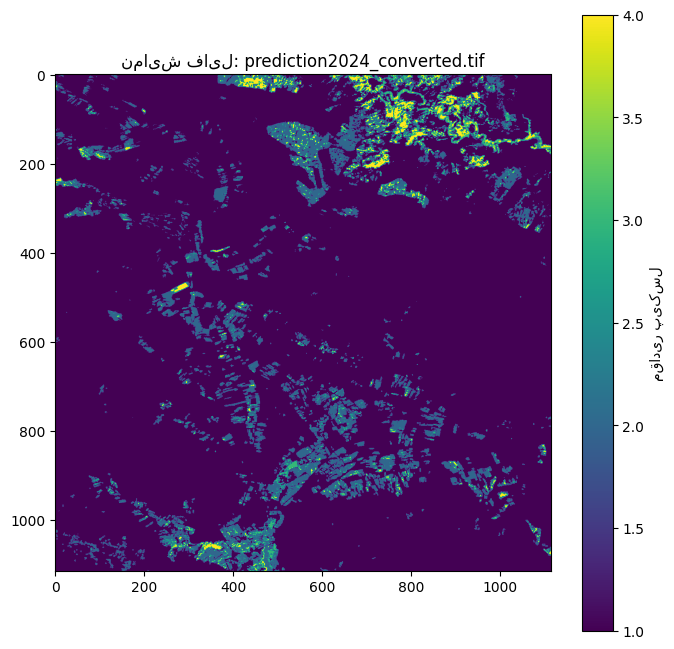

In [13]:
import rasterio
import matplotlib.pyplot as plt
import os

def convert_rst_to_tiff(rst_path, tiff_path):
    """
    یک فایل .rst را به فایل GeoTIFF .tif تبدیل می‌کند.
    """
    try:
        with rasterio.open(rst_path) as src:
            data = src.read(1)
            meta = src.meta.copy()
            meta.update(driver='GTiff')
            with rasterio.open(tiff_path, 'w', **meta) as dst:
                dst.write(data, 1)
        print(f"✅ تبدیل موفقیت آمیز بود.")
        print(f"فایل خروجی در این مسیر ذخیره شد: {tiff_path}")
        return True # در صورت موفقیت True را برمی‌گرداند
    except Exception as e:
        print(f"❌ خطا در تبدیل فایل: {e}")
        return False # در صورت شکست False را برمی‌گرداند

def display_tiff(tiff_path):
    """
    یک فایل GeoTIFF را باز کرده و نمایش می‌دهد.
    """
    try:
        with rasterio.open(tiff_path) as src:
            data = src.read(1)
            plt.figure(figsize=(8, 8))
            plt.imshow(data, cmap='viridis')
            plt.colorbar(label='مقادیر پیکسل')
            plt.title(f'نمایش فایل: {os.path.basename(tiff_path)}')
            plt.show()
    except Exception as e:
        print(f"❌ خطا در نمایش فایل: {e}")

# --- تعریف مسیرها ---

# مسیری که شما ارائه دادید
directory_path = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2024'

# !!! توجه: اگر نام فایل شما متفاوت است، آن را در اینجا تغییر دهید
rst_filename = 'prediction_2024.rst'
tiff_filename = 'prediction2024_converted.tif'

# ایجاد مسیر کامل برای فایل ورودی و خروجی
input_rst = os.path.join(directory_path, rst_filename)
output_tiff = os.path.join(directory_path, tiff_filename)


# --- اجرای اصلی: تبدیل و سپس نمایش ---
if os.path.exists(input_rst):
    # ابتدا تبدیل را انجام می‌دهیم
    success = convert_rst_to_tiff(input_rst, output_tiff)
    
    # اگر تبدیل موفق بود، فایل را نمایش می‌دهیم
    if success:
        display_tiff(output_tiff)
else:
    print(f"❌ خطا: فایل در مسیر زیر یافت نشد:")
    print(input_rst)
    print("لطفاً از صحت نام فایل و مسیر پوشه اطمینان حاصل کنید.")

In [21]:
import rasterio
import numpy as np
import os

def analyze_land_cover_change(predicted_tiff, actual_tiff):
    """
    Analyzes and reports the area and percentage of land cover change
    between a predicted and an actual GeoTIFF file.
    The output is in English and formatted for clarity.
    """
    print(f"Comparing '{os.path.basename(predicted_tiff)}' against '{os.path.basename(actual_tiff)}'...")
    try:
        with rasterio.open(predicted_tiff) as pred_src, rasterio.open(actual_tiff) as actual_src:
            # --- 1. Data and Metadata Reading ---
            pred_data = pred_src.read(1)
            actual_data = actual_src.read(1)
            transform = actual_src.transform
            crs = actual_src.crs

            if pred_data.shape != actual_data.shape:
                print("❌ ERROR: Raster shapes do not match. Please ensure both rasters have the same dimensions.")
                return

            # --- 2. Area Calculation with CRS Check ---
            pixel_area_sq_meters = 0

            # --- 3. Change Calculation ---
            changed_pixels_matrix = np.where(pred_data != actual_data, 1, 0)
            num_changed_pixels = np.sum(changed_pixels_matrix)
            total_pixels = pred_data.size

            print("\n" + "="*25 + " ANALYSIS SUMMARY " + "="*25)
            print(f"Total Changed Pixels: {num_changed_pixels:,}")

            if pixel_area_sq_meters > 0:
                total_change_area_sq_km = (num_changed_pixels * pixel_area_sq_meters) / 1_000_000
                print(f"Total Area of Change: {total_change_area_sq_km:,.2f} sq. km")
            print("="*70)

            # --- 4. Detailed Confusion Matrix ---
            classes = sorted(np.unique(np.concatenate((pred_data, actual_data))))
            num_classes = len(classes)
            class_mapping = {val: i for i, val in enumerate(classes)}

            change_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
            for r in range(pred_data.shape[0]):
                for c in range(pred_data.shape[1]):
                    actual_val = actual_data[r, c]
                    pred_val = pred_data[r, c]
                    if actual_val in class_mapping and pred_val in class_mapping:
                        change_matrix[class_mapping[actual_val], class_mapping[pred_val]] += 1
            
            # --- 5. Formatted Output Table ---
            print("\nChange Matrix (% of Total Landscape)")
            
            # Header
            header = f"{'ACTUAL':<10}" + "".join([f"{'PRED_' + str(c):^12}" for c in classes])
            print(header)
            print("-" * len(header))

            # Rows
            for i, actual_class in enumerate(classes):
                row_str = f"{'CLASS_' + str(actual_class):<10}"
                for j, _ in enumerate(classes):
                    percentage = (change_matrix[i, j] / total_pixels) * 100
                    row_str += f"{percentage:^12.2f}"
                print(row_str)
            print("-" * len(header))
            
            # --- 6. Overall Accuracy ---
            correct_pixels = np.trace(change_matrix)
            accuracy = (correct_pixels / total_pixels) * 100
            print(f"\nOverall Accuracy: {accuracy:.2f}%\n")


    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# --- File Path Definitions ---

# Path to the predicted TIF file
predicted_dir = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2024'
predicted_filename = 'prediction2024_converted.tif'
predicted_tiff_path = os.path.join(predicted_dir, predicted_filename)

# Path to your actual TIF file
actual_dir = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\new_classified'
# !!! NOTE: The actual filename is now 'reclassify2024.tif'.
actual_filename = 'reclassify2024.tif'
actual_tiff_path = os.path.join(actual_dir, actual_filename)

# --- Main Execution Block ---
if not os.path.exists(predicted_tiff_path):
    print(f"❌ ERROR: Predicted file not found at: {predicted_tiff_path}")
elif not os.path.exists(actual_tiff_path):
    print(f"❌ ERROR: Actual file not found at: {actual_tiff_path}")
else:
    analyze_land_cover_change(predicted_tiff_path, actual_tiff_path)

Comparing 'prediction2024_converted.tif' against 'reclassify2024.tif'...

========================= ANALYSIS SUMMARY =========================
Total Changed Pixels: 127,461

Change Matrix (% of Total Landscape)
ACTUAL       PRED_1      PRED_2      PRED_3      PRED_4   
----------------------------------------------------------
CLASS_1      81.54        2.16        0.16        0.08    
CLASS_2       5.83        7.11        0.49        0.58    
CLASS_3       0.07        0.11        0.29        0.12    
CLASS_4       0.08        0.45        0.12        0.80    
----------------------------------------------------------

Overall Accuracy: 89.75%



✅ تبدیل موفقیت آمیز بود.
فایل خروجی در این مسیر ذخیره شد: E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2030\prediction2030_converted.tif


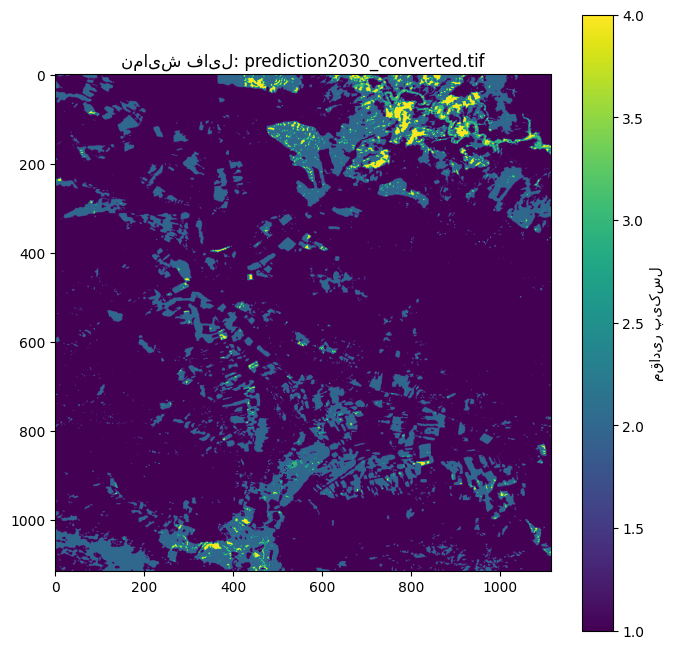

In [2]:
import rasterio
import matplotlib.pyplot as plt
import os

def convert_rst_to_tiff(rst_path, tiff_path):
    """
    یک فایل .rst را به فایل GeoTIFF .tif تبدیل می‌کند.
    """
    try:
        with rasterio.open(rst_path) as src:
            data = src.read(1)
            meta = src.meta.copy()
            meta.update(driver='GTiff')
            with rasterio.open(tiff_path, 'w', **meta) as dst:
                dst.write(data, 1)
        print(f"✅ تبدیل موفقیت آمیز بود.")
        print(f"فایل خروجی در این مسیر ذخیره شد: {tiff_path}")
        return True # در صورت موفقیت True را برمی‌گرداند
    except Exception as e:
        print(f"❌ خطا در تبدیل فایل: {e}")
        return False # در صورت شکست False را برمی‌گرداند

def display_tiff(tiff_path):
    """
    یک فایل GeoTIFF را باز کرده و نمایش می‌دهد.
    """
    try:
        with rasterio.open(tiff_path) as src:
            data = src.read(1)
            plt.figure(figsize=(8, 8))
            plt.imshow(data, cmap='viridis')
            plt.colorbar(label='مقادیر پیکسل')
            plt.title(f'نمایش فایل: {os.path.basename(tiff_path)}')
            plt.show()
    except Exception as e:
        print(f"❌ خطا در نمایش فایل: {e}")

# --- تعریف مسیرها ---

# مسیری که شما ارائه دادید
directory_path = r'E:\master_1\Msc_4032\spatial_processing\TA\AGIS_HW04__spring2025\prediction\2030'

# !!! توجه: اگر نام فایل شما متفاوت است، آن را در اینجا تغییر دهید
rst_filename = 'prediction2030.rst'
tiff_filename = 'prediction2030_converted.tif'

# ایجاد مسیر کامل برای فایل ورودی و خروجی
input_rst = os.path.join(directory_path, rst_filename)
output_tiff = os.path.join(directory_path, tiff_filename)


# --- اجرای اصلی: تبدیل و سپس نمایش ---
if os.path.exists(input_rst):
    # ابتدا تبدیل را انجام می‌دهیم
    success = convert_rst_to_tiff(input_rst, output_tiff)
    
    # اگر تبدیل موفق بود، فایل را نمایش می‌دهیم
    if success:
        display_tiff(output_tiff)
else:
    print(f"❌ خطا: فایل در مسیر زیر یافت نشد:")
    print(input_rst)
    print("لطفاً از صحت نام فایل و مسیر پوشه اطمینان حاصل کنید.")